# 4-Overfitting and Underfitting

## 데이터를 학습시킬 때 고려해야할 두가지 정보 : Signal, noise

        1. Signal: 모델이 새로운 데이터에서 예측을 수행하는데 도움되는 일반화하는 부분 (일반화 능력)
        2. Noise : 훈련 데이터에만 해당되는 부분으로 실제 데이터에서 발생하는 모든 임의의 변동 또는 모델이 실제로 예측하는데 도움이 되지 않는 모든 부수적이고 정보가 없는 패턴을 뜻함

- 즉 이러한 두 가지 정보를 반영하기 위해서 모델의 성능을 평가 할 때, train과 검증 데이터를 만들어서 평가해야 한다.
- 그림처럼 training set의 loss가 낮아진다고 해서 좋은 모델이 아님!! 그림은 노이즈까지 학습해버린 경우!
    - 즉, 특정시점이 지나면 비용이 이익을 초과하고 검증 loss가 증가한다.
    
- 일반화 능력까지 고려해주기 위해 검증 데이터를 평가해야 한다. 

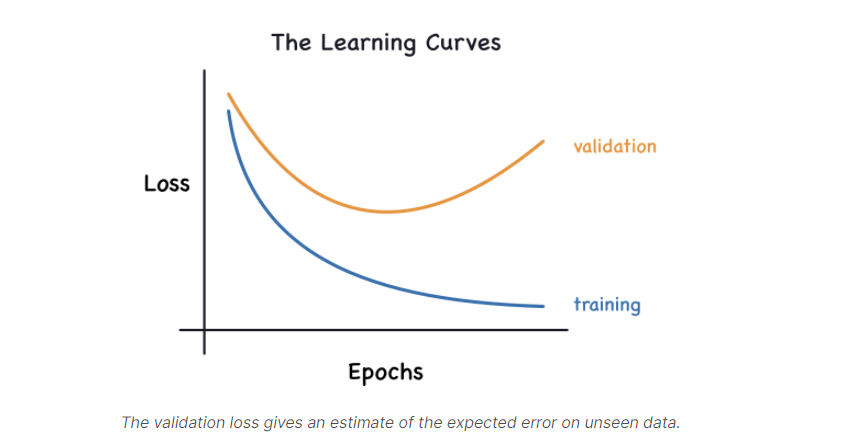

## Underfitting, Overfitting

- 구체적으로는 Underfitting과 Overfitting으로 나눌 수 있다. 
- Underfitting은 모델이 충분한 signal을 학습하지 못하여 loss가 낮은 현상을 뜻함
- Overfitting은 모델이 너무 많은 noise까지 학습하여 검증 데이터의 loss가 높은 현상을 뜻함
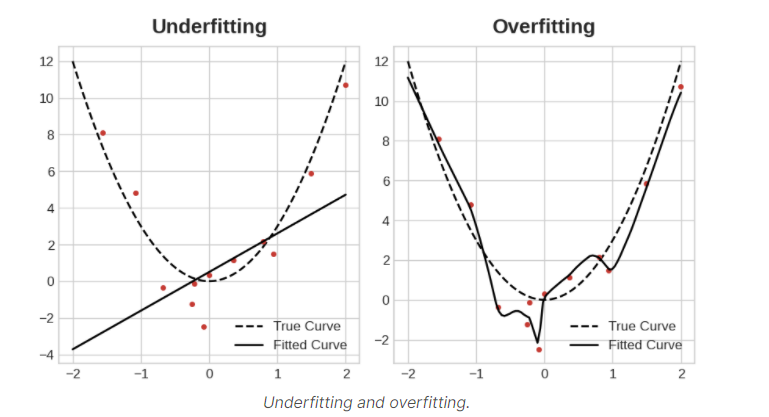
- 둘 다, 캐글에서는 training set is when the loss is not as low  이렇게 정의하는데 무슨뜻일까..?
    - 즉 , validation loss가 둘 다 높다는 뜻

## Capacity

- 모델의 capacity는 학습할 수 있는 패턴의 크기와 복잡성을 나타냄
- 신경망의 경우, 주로 얼마나 많은 뉴런이 있고, 어떻게 서로 연결되어 있는지에 따라 결정됨
- 네트워크가 데이터에 적합하지 않으면 용량을 늘려야 한다!!
    - 즉, 더 넓게 만들거나 (레이어에 더 많은 unit 추가) 혹은, 더 깊게(레이어 추가)하여 네트워크의 용량을 늘린다.
    - 더 넓은 네트워크는 더 많은 선형관계를 배우는데 수월하며, 더 깊은 네트워크는 더 많은 비선형 관계를 선호한다.
    - 데이터셋에 따라 선호될 수 있음
   
        1. 기본
           -     layers.Dense(16, activation='relu'),
           - layers.Dense(1),
        2. wide
           - layers.Dense(32, activation'relu')
           - layers.Dense(1),
        3. Deep
           - layers.Dense(16, activation='relu'),
           - layers.Dense(16, activation='relu'),
           - layers.Dense(1),

## early stopping

- 모델이 노이즈를 너무 많이 학습하면 앞에서 봤듯이, 학습 중에 검증 loss가 증가하는 추세가 나타난다.
- 따라서 이를 방지하기 위해 검증 loss가 더 이상 감소하지 않는 시점을 찾아 훈련을 중단하는 방법이 early stopping 방법이다.
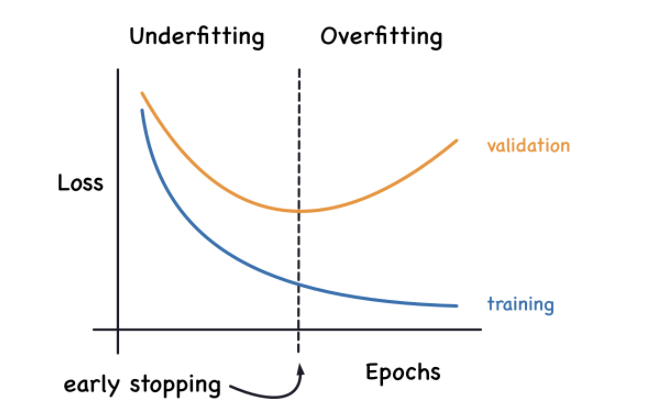
- 이를 통해 과적합이 너무 오래 훈련되는 것을 방지 + 과적합이 충분히 오래 훈련하지 않은 것을 방지도 가능

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('data/spotify.csv', encoding='UTF-8')
spotify.isnull().sum()

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [2]:
X = spotify.copy().dropna() #결측치 제외한 후 할당
y = X.pop('track_popularity') #종속변수 제거
artists = X['track_artist']
artists

0              Ed Sheeran
1                Maroon 5
2            Zara Larsson
3        The Chainsmokers
4           Lewis Capaldi
               ...       
32828        Lush & Simon
32829      Tegan and Sara
32830         Starkillers
32831              Mat Zo
32832        Julian Calor
Name: track_artist, Length: 32828, dtype: object

In [7]:
X.dtypes

track_id                     object
track_name                   object
track_artist                 object
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
dtype: object

In [3]:
# 수치형 할당
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
# 카테고리형 할당
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num), #수치형 -> 표준화
    (OneHotEncoder(), features_cat), #카테고리 -> 원핫인코딩
)


- `GroupShuffleSplit` : TRAIN과 TEST 를  group에 맞게 나누어줌 ( 이 때, index가 저장!!!)
             - 따라서, X.iloc 을 할당해줌으로써 train test를 분리한다.

In [22]:
def group_split(X, y, group, train_size=0.75):
    global train
    global test
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]) #iloc을 하는 이유: groupshufuflesplit으로 index를 split하기 때문에

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train) #train에 앞에서 정의한 preprocessor fit_transform
X_valid = preprocessor.transform(X_valid) # valid에는 transform 적용
y_train = y_train / 100 # y값을 0과 1 사이 값으로 정규화 해줌
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


- y값을 정규화하기도 하는가??? 
    - 계산량을 줄이기 위해서도 (연산속도 빠르게하기위함)

#### 모델 구축

1. Dense(1)

Epoch 1/50
49/49 [==============================] - 0s 3ms/step - loss: 1.0907 - val_loss: 1.0185
Epoch 2/50
49/49 [==============================] - 0s 1ms/step - loss: 0.9615 - val_loss: 0.8923
Epoch 3/50
49/49 [==============================] - 0s 1ms/step - loss: 0.8373 - val_loss: 0.7696
Epoch 4/50
49/49 [==============================] - 0s 1ms/step - loss: 0.7169 - val_loss: 0.6508
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.6013 - val_loss: 0.5381
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.4932 - val_loss: 0.4352
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.3963 - val_loss: 0.3465
Epoch 8/50
49/49 [==============================] - 0s 1ms/step - loss: 0.3164 - val_loss: 0.2787
Epoch 9/50
49/49 [==============================] - 0s 1ms/step - loss: 0.2612 - val_loss: 0.2373
Epoch 10/50
49/49 [==============================] - 0s 1ms/step - loss: 0.2290 - val_loss: 0.2148
Epoch 11/50
49/49 [

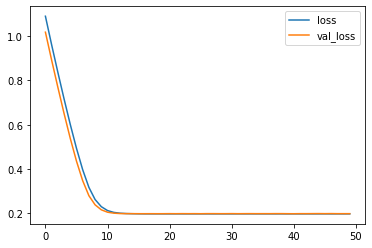

In [38]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=1,
)

#시각화로 loss확인
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot() #검증 loss에 대해 확인한다.

print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.1992


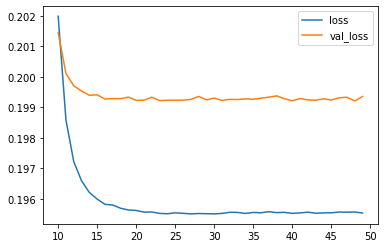

In [38]:
# 10 에포크 뒤로는 변화가 거의 없음!!
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

- 2.Dense layer
        Dense(128)
        Dense(64)
        Dense(1)

Epoch 1/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2529 - val_loss: 0.2085
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.2010 - val_loss: 0.2042
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1965 - val_loss: 0.2011
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1937 - val_loss: 0.2005
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1914 - val_loss: 0.1998
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1901 - val_loss: 0.1999
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1893 - val_loss: 0.1992
Epoch 8/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1881 - val_loss: 0.1992
Epoch 9/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1869 - val_loss: 0.1985
Epoch 10/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1860 - val_loss: 0.1981
Epoch 11/50
48/48 [

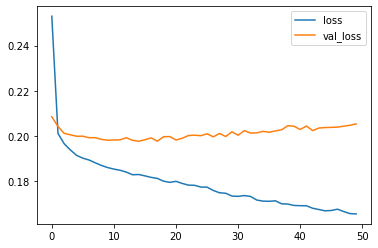

In [39]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

- val loss가 매우 일찍부터 증가하는 것을 확인할 수 있다. 
- **이는 네트워크가 벌써부터 과적합되기 시작했음을 뜻함!!!**
- 따라서 unit 수나 early stopping을 해야 함!

#### early stopping 도입

- monitor : 관찰하고자 하는 항목: ‘val_loss’나 ‘val_acc’
- min_delta : 개선되고 있다고 판단하기 위한 최소 변화량
        - 만약 변화량이 min_delta보다 적은 경우에는 개선이 없다고 판단
- patience : 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄 것인 가를 지정
       - 만약 10이라고 지정하면 개선이 없는 에포크가 10번째 지속될 경우 학습일 종료
- verbose : 얼마나 자세하게 정보를 표시할 것인가를 지정 (0, 1, 2)
- mode : 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 지정
        - 예를 들어 관찰 항목이 ‘val_loss’인 경우에는 감소되는 것이 멈출 때 종료되어야 하므로, ‘min’으로 설정
- auto : 관찰하는 이름에 따라 자동으로 지정
- min : 관찰하고 있는 항목이 감소되는 것을 멈출 때 종료
- max : 관찰하고 있는 항목이 증가되는 것을 멈출 때 종료

In [36]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Epoch 1/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2318 - val_loss: 0.2126
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.2011 - val_loss: 0.2049
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1956 - val_loss: 0.2017
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1929 - val_loss: 0.2008
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1908 - val_loss: 0.2011
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1893 - val_loss: 0.1994
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1883 - val_loss: 0.1993
Epoch 8/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1870 - val_loss: 0.2001
Epoch 9/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1858 - val_loss: 0.1999
Epoch 10/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1849 - val_loss: 0.1998
Epoch 11/50
48/48 [

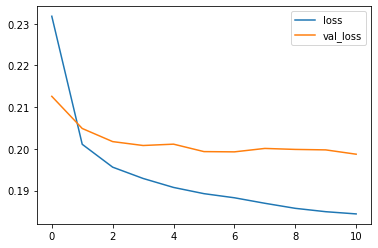

In [41]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

- 11epoch에 중단하는 것을 볼 수 있음
- 즉, patience 5를 주었기 때문에 1.9993으로부터 5번되기 전에 val_loss가 개선이 없으면 stop 해버림